In [90]:
import lzma
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import figure_options
from figure_options import plt, sns, rc_parameters
from scipy.stats import bootstrap
from environment import run_experiment, RunParameters, RunStatistics
from baifg.model.feedback_graph import FeedbackGraph
from baifg.model.reward_model import GaussianRewardModel, RewardType
from baifg.algorithms.eps_greedy import EpsilonGreedy, EpsilonGreedyParameters
from baifg.algorithms.ucb import UCB
from baifg.algorithms.exp3g import Exp3G, Exp3GParameters
from baifg.algorithms.tas_fg import TaSFG, TaSFGParameters
from baifg.algorithms.base.graph_estimator import GraphEstimator
from baifg.algorithms.base.base_algorithm import BaseAlg
from baifg.utils.graphs import make_loopless_clique, make_loopystar_graph
from baifg.utils.characteristic_time import compute_characteristic_time
from itertools import product
from typing import List, NamedTuple
from tqdm import tqdm

colors = ['#00bfc4', 'mediumorchid', '#7f7f7f','#f8766d', '#3B3B3B','#0096FF','#a3a500']

In [63]:
filename = 'full_data.lzma'


with open(filename, 'rb') as f:
    data = pickle.load(f)

df = data['df']

In [94]:
df.head()

,env,K,seed,algorithm,delta,stopping_time,identified_optimal_arm
0,Loopless clique,5,0,Epsilon-greedy,0.367879,378,True
1,Loopless clique,5,0,Epsilon-greedy IG,0.367879,190,True
2,Loopless clique,5,0,EXP3.G,0.367879,2537,True
3,Loopless clique,5,0,TaSFG,0.367879,566,True
4,Loopless clique,5,0,UCB,0.367879,6,False


In [93]:
# Define the grouping columns
group_cols = ['env', 'K', 'algorithm', 'delta']

# Group the DataFrame
grouped = df.groupby(group_cols)

# Define a function to compute mean and confidence intervals
def compute_stats(group, n_boot=1000, ci=95):
    data = group['stopping_time'].astype(float).values  # Convert bool to int (True=1, False=0)
    mean = data.mean()
    res = bootstrap((data,), np.mean)
    return pd.Series({
        'mean_identified_optimal_arm': mean,
        'ci_lower': res.confidence_interval.low,
        'ci_upper': res.confidence_interval.high
    })

# Apply the function to each group
result = grouped.apply(compute_stats).reset_index()
result

C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\3062555142.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(compute_stats).reset_index()


,env,K,algorithm,delta,mean_identified_optimal_arm,ci_lower,ci_upper
0,Loopless clique,5,EXP3.G,0.006738,2159.83,1891.052510,2447.086494
1,Loopless clique,5,EXP3.G,0.025562,1540.63,1307.022338,1813.259743
2,Loopless clique,5,EXP3.G,0.096972,1086.68,888.723795,1331.004972
3,Loopless clique,5,EXP3.G,0.367879,539.36,409.187657,725.731854
4,Loopless clique,5,Epsilon-greedy,0.006738,3368.13,2958.400307,3873.735321
...,...,...,...,...,...,...,...
115,Loopystar,15,TaSFG,0.367879,279.49,217.114136,351.679546
116,Loopystar,15,UCB,0.006738,3977.46,3459.632234,4441.358474
117,Loopystar,15,UCB,0.025562,1741.69,1489.947463,1984.248477
118,Loopystar,15,UCB,0.096972,860.20,704.736722,1030.562691


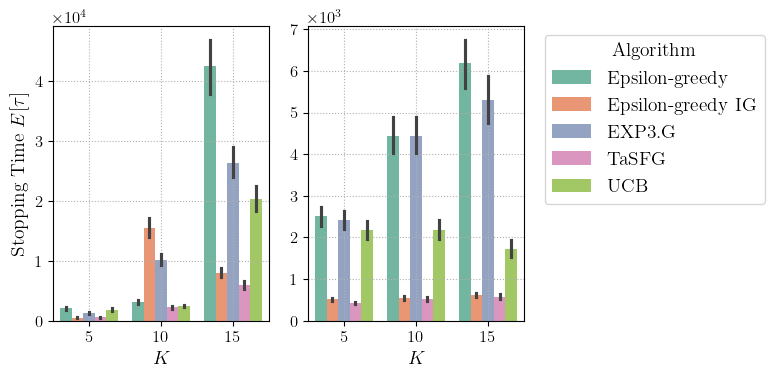

In [119]:
envs = df['env'].unique()

fig, ax = plt.subplots(1,2, figsize=(8,4))
for idx, env_name in enumerate(envs):

    # Filter the DataFrame for the selected environment
    df_env = df[df['env'] == env_name]

    # Create a boxplot
    # sns.boxplot(
    #     x='K',
    #     y='stopping_time',
    #     hue='algorithm',
    #     data=df_env,
    #     palette='Set2',
    #     ax=ax[idx]
    # )
    sns.barplot(
    x='K',
    y='stopping_time',
    hue='algorithm',
    data=df_env,
    palette='Set2',
    errorbar=('ci', 95),           # Confidence interval
    #capsize=0.1,      # Width of the error bar caps
    estimator='mean',  # Function to estimate central tendency
    ax=ax[idx],
    legend=True if idx == len(envs)-1 else False
)
    ax[idx].set_ylabel(r'')
    # ax[idx].set_yscale('log')
    ax[idx].set_xlabel('$K$')
    
    ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # Adjust legend
    if idx == 0:
        ax[idx].set_ylabel(r'Stopping Time $E[\tau]$')
    if idx == len(envs)-1:
        ax[idx].legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[idx].grid(linestyle = ":")
# Show the plot
plt.tight_layout()
plt.show()


C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\2983151942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\2983151942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\2983151942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

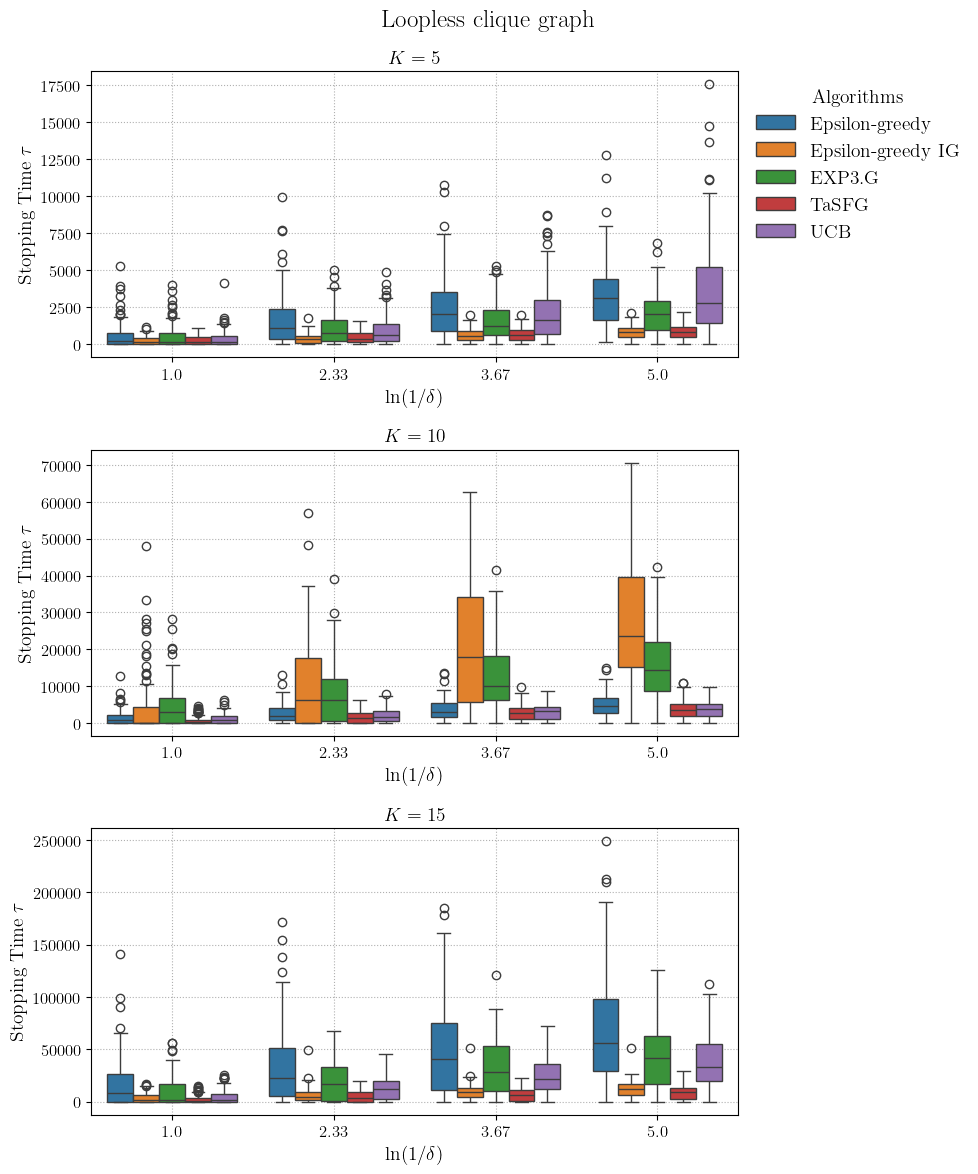

C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\2983151942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\2983151942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\2983151942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

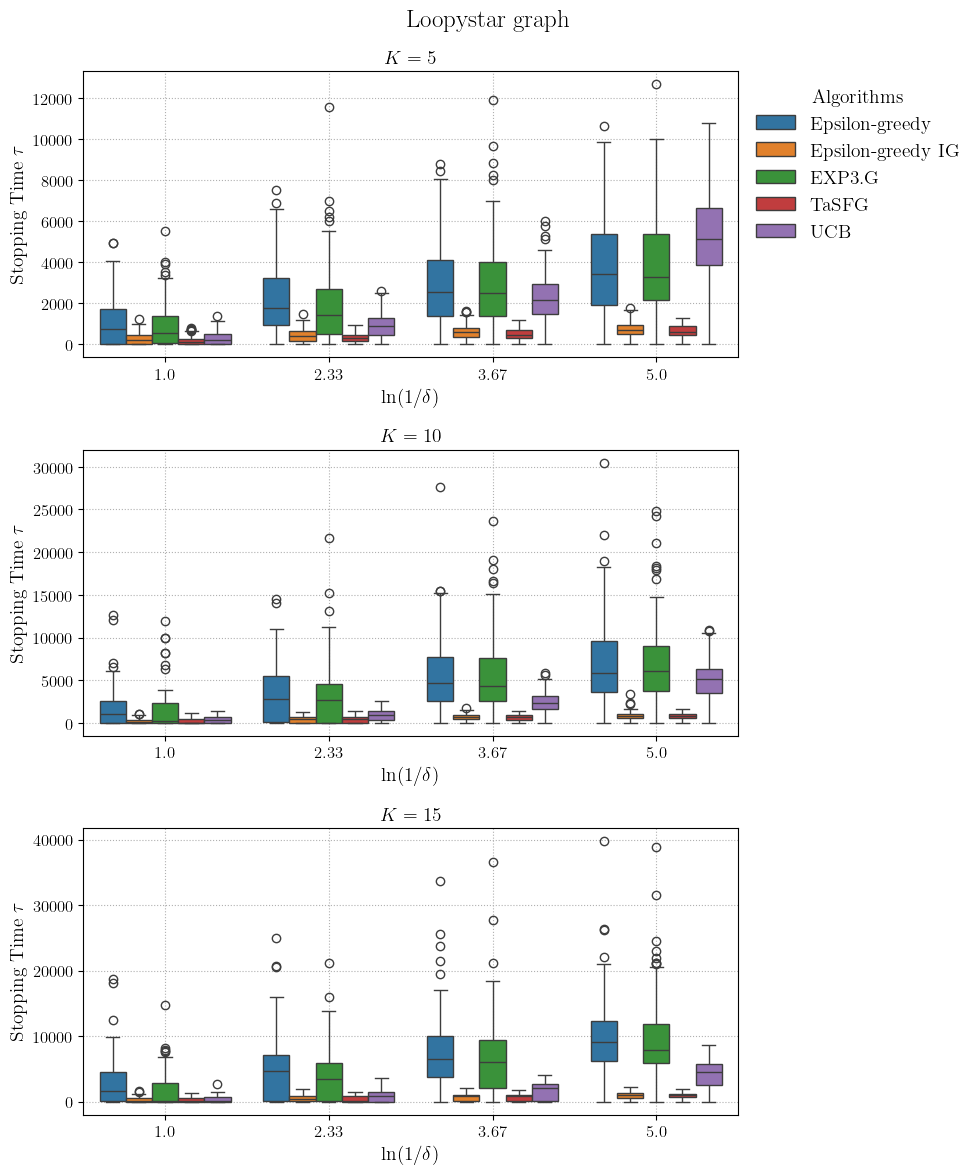

In [77]:
Kvalues = df['K'].unique()
envs = df['env'].unique()

for envname  in envs:
    fig, ax = plt.subplots(len(Kvalues), 1, figsize=(10,12))
    for idx, K in enumerate(Kvalues):
        # Filter the DataFrame for a given environment, e.g., "Loopless clique"
        filtered_df = df[(df['env'] == envname) & (df['K'] == K)]
        filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
        sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df, ax=ax[idx], legend=True if idx ==0 else False)

        # Customize labels
        ax[idx].set_xlabel(r'$\ln(1/\delta)$')
        ax[idx].set_ylabel(r'Stopping Time $\tau$')
        ax[idx].set_title(f'$K={K}$')
        ax[idx].grid(linestyle = ":")
    # Display the plot
    ax[0].legend(title='Algorithms', bbox_to_anchor=(1., 1.), ncols=1, frameon=False)
    
    plt.suptitle(f'{envname} graph')
    plt.tight_layout()
    plt.show()

C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\233386392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\233386392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\233386392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

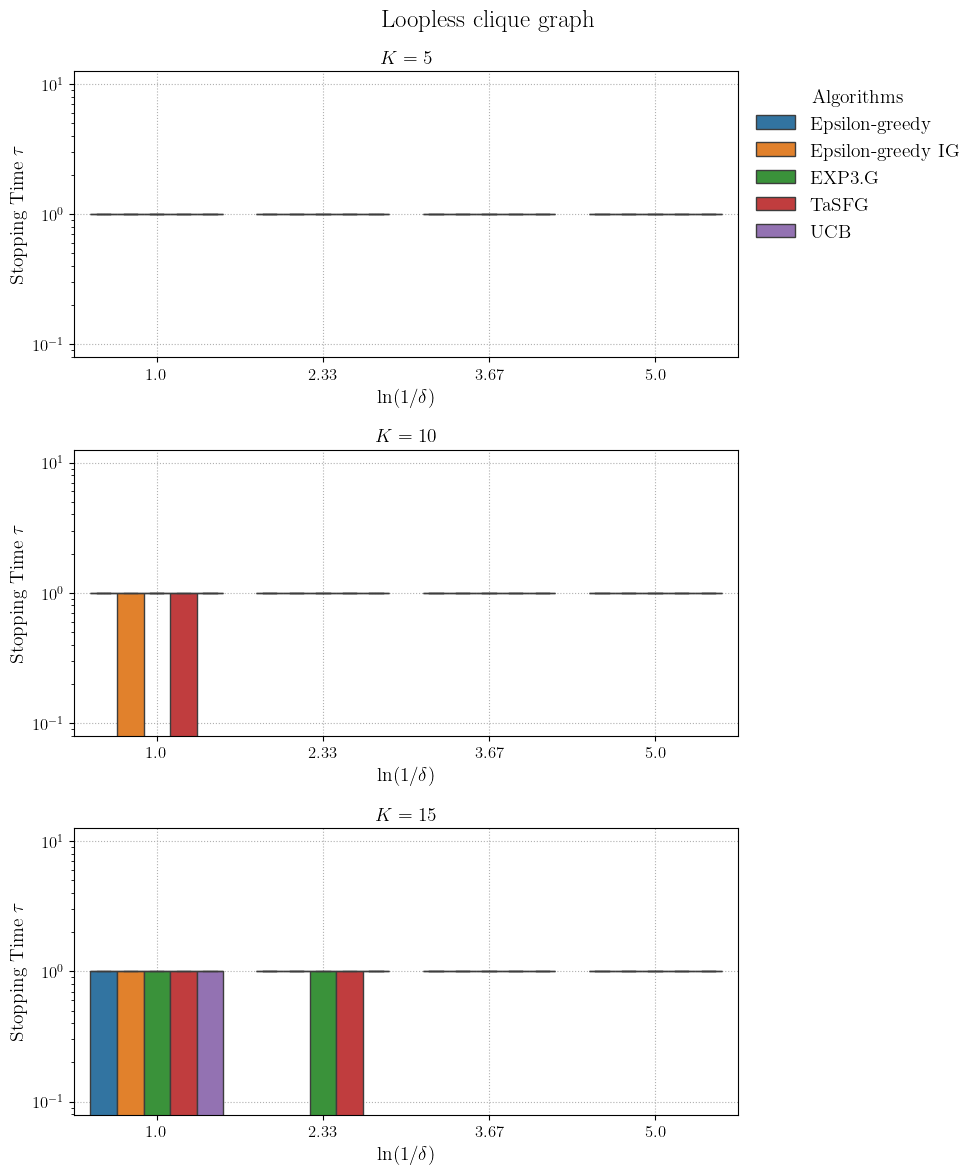

C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\233386392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\233386392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_28372\233386392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

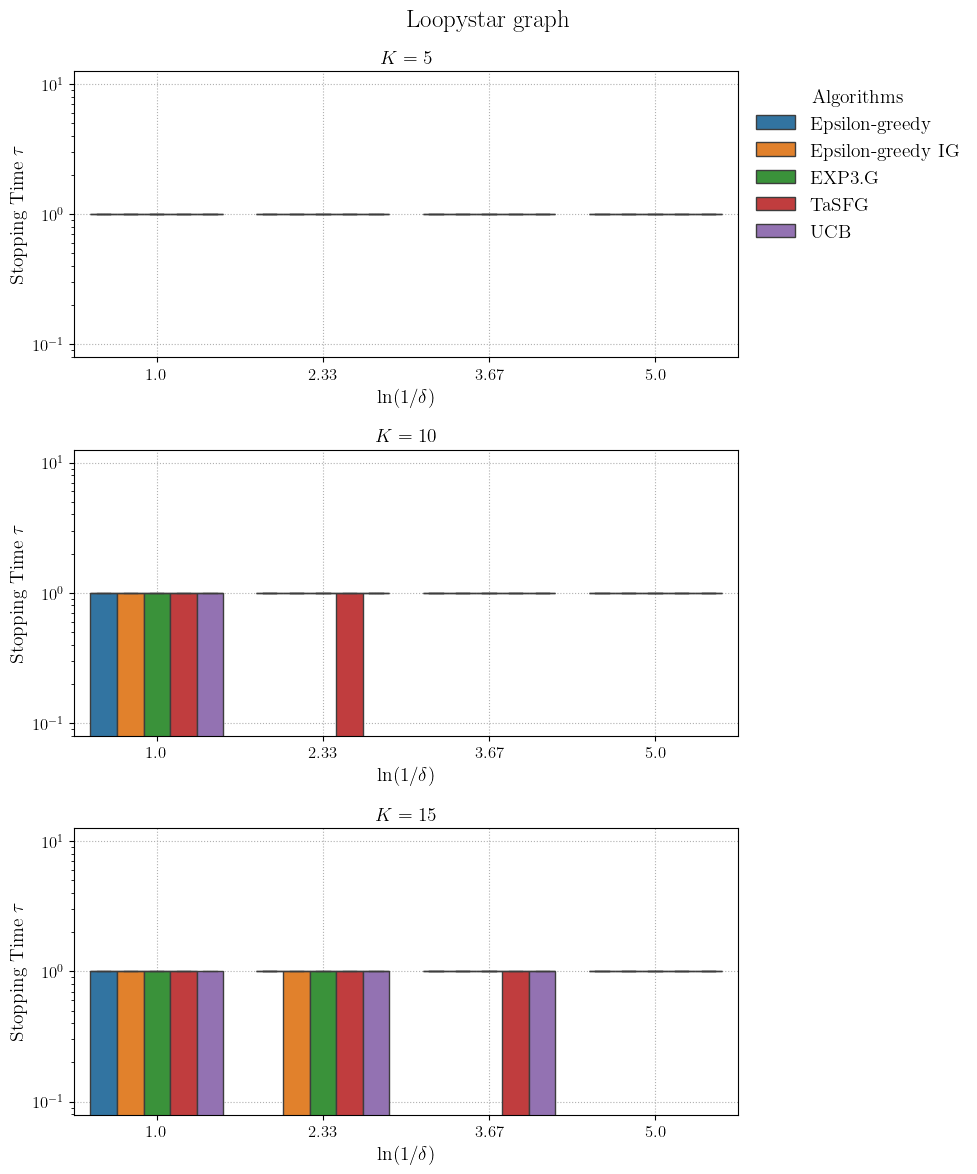

In [85]:
Kvalues = df['K'].unique()
envs = df['env'].unique()

for envname  in envs:
    fig, ax = plt.subplots(len(Kvalues), 1, figsize=(10,12))
    for idx, K in enumerate(Kvalues):
        # Filter the DataFrame for a given environment, e.g., "Loopless clique"
        filtered_df = df[(df['env'] == envname) & (df['K'] == K)]
        filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
        sns.boxplot(x='delta', y='identified_optimal_arm', hue='algorithm', data=filtered_df, ax=ax[idx], legend=True if idx ==0 else False)

        # Customize labels
        ax[idx].set_xlabel(r'$\ln(1/\delta)$')
        ax[idx].set_ylabel(r'Stopping Time $\tau$')
        ax[idx].set_title(f'$K={K}$')
        ax[idx].grid(linestyle = ":")
        ax[idx].set_yscale('log')
    # Display the plot
    ax[0].legend(title='Algorithms', bbox_to_anchor=(1., 1.), ncols=1, frameon=False)
    
    plt.suptitle(f'{envname} graph')
    plt.tight_layout()
    plt.show()